## FIGRL

In [1]:
intermediate_dimension = 100
final_dimension = 10

In [2]:
# ## FI-GRL (Python)
import networkx as nx
import pandas as pd 
import numpy as np
import scipy
from scipy.sparse import csr
from components.GraphConstruction import GraphConstruction

df = pd.read_csv("demo_ccf.csv")
df = df.set_index(df.index+1)

#### Train-Inductive Split

In [3]:
cutoff = round(0.6*len(df)) # first 60% of transactions are used for training, last 40% to test inductive capability
train_data = df.head(cutoff)
inductive_data = df.tail(len(df)-cutoff)

#### Graph Construction

In [4]:
nodes = {"transaction":train_data.index,"client":train_data.client_node, "merchant":train_data.merchant_node}
edges = [zip(train_data.client_node, train_data.index),zip(train_data.merchant_node, train_data.index)]

In [5]:
g_nx = nx.Graph()
for key, values in nodes.items():
            g_nx.add_nodes_from(values, ntype=key)
for edge in edges:
            g_nx.add_edges_from(edge)

In [6]:
pd.options.mode.chained_assignment = None

train_data['index'] = train_data.index
inductive_data['index'] = inductive_data.index
inductive_graph_data = pd.concat((train_data,inductive_data))
inductive_graph_data = inductive_graph_data.set_index(inductive_graph_data['index']).drop("index",axis = 1)

## Train

In [7]:
A = nx.adjacency_matrix(g_nx)
print(A.shape)
dim = intermediate_dimension

(1525, 1525)


In [8]:
n = len(g_nx)
diags = A.sum(axis=1).flatten()
#D = scipy.sparse.spdiags(diags, [0], n, n, format='csr')

with scipy.errstate(divide='ignore'):
   diags_sqrt = 1.0/np.lib.scimath.sqrt(diags)
diags_sqrt[np.isinf(diags_sqrt)] = 0
DH = scipy.sparse.spdiags(diags_sqrt, [0], n, n, format='csr')

Normalized_random_walk = (DH.dot(A)).dot(DH)

S = np.random.randn(n, dim) / np.sqrt(dim)

C = Normalized_random_walk.dot(S)

from scipy import sparse
sC = sparse.csr_matrix(C)

U, sigma, V = scipy.sparse.linalg.svds(sC, k=final_dimension, tol=0,which='LM')
print('Sparse C: ')
print(sC.shape)
print('S: ')
print(S.shape)
print('U:')
print(U.shape)
print('sigma:')
print(sigma.shape)
print(V.shape)
V = V.transpose()
print(V.shape)
print(A.shape)

Sparse C: 
(1525, 100)
S: 
(1525, 100)
U:
(1525, 10)
sigma:
(10,)
(10, 100)
(100, 10)
(1525, 1525)


In [9]:
sigma = np.diag(sigma)
sigma.shape

(10, 10)

In [10]:
V.shape

(100, 10)

#### Save embeddings

In [11]:
figrl_train_emb = pd.DataFrame(U)
figrl_train_emb = figrl_train_emb.set_index(figrl_train_emb.index+1)
figrl_train_emb = figrl_train_emb.loc[train_data.index]
#figrl_train_emb = figrl_train_emb.iloc[:len(train_data.index),:]

In [12]:
train_data.index

RangeIndex(start=1, stop=647, step=1)

In [13]:
import numpy as np
sigma = np.array(sigma)
V = np.array(V)
S = np.array(S)

## Inductive

In [14]:
max(train_data.merchant_node)

100473

In [15]:
nodes = {"transaction":inductive_graph_data.index, "client":inductive_graph_data.client_node, "merchant":inductive_graph_data.merchant_node}
edges = [zip(inductive_graph_data.client_node, inductive_graph_data.index),zip(inductive_graph_data.merchant_node, inductive_graph_data.index)]

graph = nx.Graph()
for key, values in nodes.items():
            graph.add_nodes_from(values, ntype=key)
for edge in edges:
            graph.add_edges_from(edge)

In [16]:
print(len(graph))

2444


Use of the original S 

In [17]:
##x,y = S.shape

##Si = np.random.randn((max(inductive_graph_data.merchant_node)-x), dim) / np.sqrt(dim)
##print(Si.shape)
##S = np.vstack((S,Si))
##print(S.shape)

In [18]:
import collections

inductive_dict = {}
for node in inductive_data.index:
    client = inductive_data.loc[node].client_node
    merchant = inductive_data.loc[node].merchant_node
    inductive_dict[node] = [client,merchant]
inductive_dict = collections.OrderedDict(sorted(inductive_dict.items()))

In [19]:
import networkx as nx
degrees = nx.degree(graph)
train_degrees = dict(degrees)
train_degrees = collections.OrderedDict(sorted(train_degrees.items()))


In [20]:
from scipy.sparse import coo_matrix
def get_vector(inductive_dict, max_id):
    print("creating sparse vector matrix")
    row  = []
    col  = []
    data = []
    i = 0
    k = 0
    for node, v in inductive_dict.items():
        for n in v:
            if n is not None:
                row.append(i)
                col.append(k)
                
                #calculate value
                inductive_degree = len([x for x in v if x != None])
                value = 1/np.sqrt(inductive_degree)
                value = value * (1/np.sqrt(train_degrees[n]))
                data.append(value)
                k+=1
        i+=1        
    row = np.array(row)
    col = np.array(col)
    data = np.array(data)
    return coo_matrix((data, (row, col)), shape=(len(inductive_dict), k))


In [21]:
import time
t0 = time.time()
v = get_vector(inductive_dict, max(inductive_graph_data.merchant_node))
t1 = time.time()
print(t1-t0)

creating sparse vector matrix
0.0050048828125


In [22]:
v.shape

(430, 860)

In [23]:
x,y = v.shape
S = S[:y,:]

In [24]:
#v = v[:,:x]

In [25]:
import scipy as sp
import scipy.sparse

t0 = time.time()
inductive_degrees = []
for l in inductive_dict.values():
    x = 0
    for i in l:
        if i is not None:
            x+=1                     
    inductive_degrees.append(x)
    
def sqrt_d_inv(inductive_degrees):
        sqrt_d_inv = np.array([1/np.sqrt(degree)  if degree > 0 else 0 for degree in inductive_degrees])
        return sp.sparse.spdiags(sqrt_d_inv,0, sqrt_d_inv.size, sqrt_d_inv.size)
sqrt_d_inv = sqrt_d_inv(inductive_degrees)
t1 = time.time()
print(t1-t0)

0.002003192901611328


In [26]:
t0 = time.time()
p = v.dot(S)
U =(p.dot(V)).dot(np.linalg.inv(sigma))
U = sqrt_d_inv.dot(U)
t1 = time.time()

print(t1-t0)


0.002001523971557617


In [27]:
figrl_inductive_emb = pd.DataFrame(U, index=inductive_data.index)

## Evaluation

In [28]:
from xgboost import XGBClassifier
classifier = XGBClassifier(n_estimators=100)

In [29]:
train_labels = train_data['fraud_label']
add_additional_data = True
if add_additional_data is True:
    train_emb = pd.merge(figrl_train_emb, train_data.loc[figrl_train_emb.index].drop('fraud_label', axis=1), left_index=True, right_index=True)
    inductive_emb = pd.merge(figrl_inductive_emb, inductive_data.loc[figrl_inductive_emb.index].drop('fraud_label', axis=1), left_index=True, right_index=True)

    baseline_train = train_data.drop('fraud_label', axis=1)
    baseline_inductive = inductive_data.drop('fraud_label', axis=1)

    classifier.fit(baseline_train, train_labels)
    baseline_predictions = classifier.predict_proba(baseline_inductive)
    
classifier.fit(train_emb, train_labels)
predictions = classifier.predict_proba(inductive_emb)


Average precision-recall score for  FI-GRL+features  configuration XGBoost: 0.8457351591
Average precision-recall score for  Baseline  configuration XGBoost: 0.8197498524


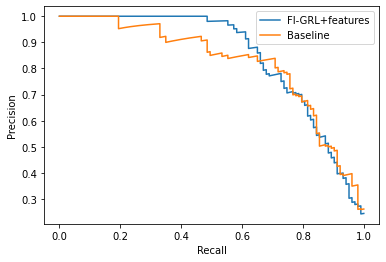

In [30]:
from components.Evaluation import Evaluation
inductive_labels = df.loc[inductive_emb.index]['fraud_label']

figrl_evaluation = Evaluation(predictions, inductive_labels, "FI-GRL+features") 
figrl_evaluation.pr_curve()

if add_additional_data is True:
    baseline_evaluation = Evaluation(baseline_predictions, inductive_labels, "Baseline")
    baseline_evaluation.pr_curve()